# Lesson 19 — Reinforcement Learning III: Finite-Horizon MDPs + Linear Quadratic Regulator (LQR)

This lesson follows the CS229 flow in the RL lectures:

**A. Generalizing MDPs**
- Rewards that depend on both state and action: $R(s,a)$

**B. Finite-Horizon MDPs**
- Time-dependent optimal values $V_t^\*(s)$ and non-stationary optimal policies $\pi_t^\*(s)$
- Dynamic programming (backward recursion) rather than “iterate until convergence”

**C. Continuous-state control via LQR**
- Linear dynamics with quadratic costs
- Exact solution via backward recursion (Riccati-style)
- The *optimal policy* does **not** depend on the noise covariance $\Sigma_w$

---

## Goals

By the end, you should be able to:

1. Write Bellman optimality when rewards are $R(s,a)$.
2. Solve a **finite-horizon** discrete MDP with backward dynamic programming.
3. Derive and implement LQR in **pure NumPy**:
   - quadratic value function $V_t^*(s)= s^top \Phi_t s + \Psi_t$
   - linear optimal policy $a_t = L_t s_t$
4. Visualize:
   - time-dependent values and policies in a small grid MDP
   - LQR value contours and the induced linear feedback vector field
   - (Optional) a single 3D plot of the LQR value surface

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

## A) State-action rewards $R(s,a)$

In many problems, actions themselves have costs.

So we use:
$$
R: \mathcal{S}\times \mathcal{A} \to \mathbb{R}, \quad R(s,a).
$$

Bellman optimality becomes:
$$
V^\*(s)=\max_{a\in\mathcal{A}} \left( R(s,a) + \gamma \sum_{s'} P(s' \mid s,a)\,V^\*(s') \right).
$$

## B) Finite-horizon MDPs: $V_t^\*(s)$ depends on time

Define the optimal value at time $t$:
$$
V_t^\*(s) = \max_{\pi_t,\pi_{t+1},\ldots,\pi_{T-1}} \mathbb{E}\left[\sum_{k=t}^{T-1} \gamma^{k-t} R(s_k, a_k) \mid s_t=s \right].
$$

Backward dynamic programming recursion:
$$
V_t^\*(s)=\max_{a}\left(R(s,a)+\gamma \sum_{s'} P(s'|s,a)\,V_{t+1}^\*(s')\right),
\quad t=T-1,T-2,\ldots,0,
$$
with terminal condition:
$$
V_T^\*(s)=0.
$$

### Demo: a tiny finite-horizon grid MDP (time-dependent policy)

We’ll build a small grid where you get terminal rewards, and a small living penalty.

We’ll visualize:
- values + greedy policy at $t=0$
- values + greedy policy near the end (almost no time left)

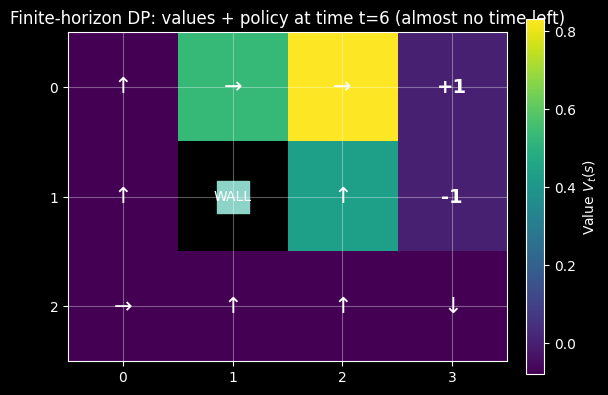

In [2]:
# ---------------------------
# Finite-horizon grid MDP
# ---------------------------

ACTIONS = ["U","D","L","R"]
A2D = {"U":(-1,0), "D":(1,0), "L":(0,-1), "R":(0,1)}
ARROWS = {"U":"↑", "D":"↓", "L":"←", "R":"→"}

class FiniteHorizonGrid:
    def __init__(self, n_rows=3, n_cols=4, wall_rc=(1,1), terminals=None,
                 living_reward=-0.04, gamma=0.95, p_intended=0.8, p_left=0.1, p_right=0.1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.wall_rc = wall_rc
        self.terminals = terminals if terminals is not None else {(0,3): +1.0, (1,3): -1.0}
        self.living_reward = living_reward
        self.gamma = gamma
        self.p_intended, self.p_left, self.p_right = p_intended, p_left, p_right

        self.states = [(r,c) for r in range(n_rows) for c in range(n_cols) if (r,c)!=wall_rc]
        self.s2i = {rc:i for i,rc in enumerate(self.states)}
        self.i2s = {i:rc for rc,i in self.s2i.items()}

    def in_bounds(self, rc):
        r,c = rc
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols and rc != self.wall_rc

    def is_terminal(self, s):
        return self.i2s[s] in self.terminals

    def _move(self, rc, a):
        dr, dc = A2D[a]
        rc2 = (rc[0]+dr, rc[1]+dc)
        if not self.in_bounds(rc2):
            return rc
        return rc2

    def transition_probs(self, s, a):
        rc = self.i2s[s]
        if rc in self.terminals:
            return {s: 1.0}

        if a in ("U","D"):
            left, right = "L", "R"
        else:
            left, right = "U", "D"

        outcomes = [(a, self.p_intended), (left, self.p_left), (right, self.p_right)]
        probs = {}
        for a2,p in outcomes:
            rc2 = self._move(rc, a2)
            s2 = self.s2i[rc2]
            probs[s2] = probs.get(s2, 0.0) + p
        return probs

def finite_horizon_dp(mdp: FiniteHorizonGrid, T=20):
    nS = len(mdp.states)
    V = np.zeros((T+1, nS), dtype=np.float64)   # V[T]=0
    pi = -np.ones((T, nS), dtype=np.int64)

    for t in range(T-1, -1, -1):
        for s in range(nS):
            if mdp.is_terminal(s):
                V[t,s] = 0.0
                pi[t,s] = -1
                continue

            q = np.zeros(len(ACTIONS))
            for ai, a in enumerate(ACTIONS):
                exp_next = 0.0
                for s2, p in mdp.transition_probs(s, a).items():
                    r = mdp.living_reward
                    if mdp.i2s[s2] in mdp.terminals:
                        r += mdp.terminals[mdp.i2s[s2]]
                    exp_next += p * (r + mdp.gamma * V[t+1, s2])
                q[ai] = exp_next

            pi[t,s] = int(np.argmax(q))
            V[t,s] = np.max(q)

    return V, pi

def plot_grid_values_and_policy(mdp: FiniteHorizonGrid, V_t, pi_t, title):
    grid = np.full((mdp.n_rows, mdp.n_cols), np.nan)
    for s, (r,c) in mdp.i2s.items():
        grid[r,c] = V_t[s]

    plt.figure(figsize=(6.2,4.6))
    im = plt.imshow(grid, origin="upper")
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Value $V_t(s)$")

    # wall
    wr, wc = mdp.wall_rc
    plt.scatter([wc],[wr], marker="s", s=550)
    plt.text(wc, wr, "WALL", ha="center", va="center")

    # terminals
    for (tr,tc), rew in mdp.terminals.items():
        plt.text(tc, tr, f"{rew:+.0f}", ha="center", va="center", fontsize=14, color="white", weight="bold")

    # arrows
    for s, (r,c) in mdp.i2s.items():
        if (r,c)==mdp.wall_rc or (r,c) in mdp.terminals:
            continue
        a_idx = pi_t[s]
        a = ACTIONS[a_idx]
        plt.text(c, r, ARROWS[a], ha="center", va="center", fontsize=16, color="white")

    plt.title(title)
    plt.xticks(range(mdp.n_cols))
    plt.yticks(range(mdp.n_rows))
    plt.grid(color="white", alpha=0.35)
    plt.show()

mdp_small = FiniteHorizonGrid()
T = 8
V, pi = finite_horizon_dp(mdp_small, T=T)

plot_grid_values_and_policy(mdp_small, V_t=V[0],    pi_t=pi[0],    title="Finite-horizon DP: values + policy at time t=0")
plot_grid_values_and_policy(mdp_small, V_t=V[T-2],  pi_t=pi[T-2],  title=f"Finite-horizon DP: values + policy at time t={T-2} (almost no time left)")

## C) LQR: continuous state control with an exact solution

Linear stochastic dynamics:
$$
s_{t+1} = A s_t + B a_t + w_t, \quad w_t \sim \mathcal{N}(0, \Sigma_w).
$$

Quadratic reward (negative cost):
$$
R(s_t,a_t) = -\left( s_t^\top U s_t + a_t^\top W a_t \right).
$$

### CS229 structural facts

1. The optimal value function is quadratic:
$$
V_t^\*(s) = s^\top \Phi_t s + \Psi_t.
$$

2. The optimal policy is linear:
$$
a_t^\*(s) = L_t s.
$$

3. In LQR, the optimal *policy* does **not** depend on $\Sigma_w$ (noise covariance).
The noise only affects the constant term in the value. 

### Cost-form LQR (easiest to implement)

We implement the standard finite-horizon discrete-time LQR recursion for:

Dynamics:
$$
s_{t+1} = A s_t + B a_t
$$

Cost:
$$
J = \sum_{t=0}^{T-1} \left(s_t^\top Q s_t + a_t^\top R a_t\right) + s_T^\top Q_f s_T
$$

Optimal feedback:
$$
a_t^\* = -K_t s_t
$$

In [3]:
# ---------------------------
# Finite-horizon discrete-time LQR in NumPy
# ---------------------------

def lqr_finite_horizon(A, B, Q, R, Qf, T):
    """
    Finite-horizon LQR for:
        s_{t+1} = A s_t + B a_t
        cost = sum_{t=0..T-1} s_t^T Q s_t + a_t^T R a_t + s_T^T Qf s_T

    Returns:
        K_list: list length T with feedback gains a_t = -K_t s_t
        P_list: list length (T+1) with cost-to-go matrices P_t
    """
    P = Qf.copy()
    K_list = []
    P_list = [None]*(T+1)
    P_list[T] = P

    for t in range(T-1, -1, -1):
        S = R + B.T @ P @ B                 # (m x m)
        K = np.linalg.solve(S, B.T @ P @ A) # (m x n)
        P = Q + A.T @ P @ A - A.T @ P @ B @ K
        K_list.insert(0, K)
        P_list[t] = P

    return K_list, P_list

def simulate_lqr(A, B, K_list, x0, T, Sigma_w=None, seed=0):
    rng = np.random.default_rng(seed)
    n = A.shape[0]
    m = B.shape[1]
    x = np.zeros((T+1, n), dtype=np.float64)
    u = np.zeros((T, m), dtype=np.float64)
    x[0] = x0

    for t in range(T):
        K = K_list[t]
        u[t] = -(K @ x[t])
        w = np.zeros(n)
        if Sigma_w is not None:
            w = rng.multivariate_normal(mean=np.zeros(n), cov=Sigma_w)
        x[t+1] = A @ x[t] + B @ u[t] + w

    return x, u

### 2D “robot” linear system

State:
$$
s_t = \begin{bmatrix} x_t \\ y_t \end{bmatrix}
$$

Action:
$$
a_t = \begin{bmatrix} u_{x,t} \\ u_{y,t} \end{bmatrix}
$$

Dynamics (very simple):
$$
s_{t+1} = s_t + a_t + w_t
$$

So $A=I$ and $B=I$.

In [4]:
# 2D point-mass-like system
A = np.eye(2)
B = np.eye(2)

Q  = np.diag([1.0, 1.0])     # state cost
R  = np.diag([0.15, 0.15])   # action cost
Qf = np.diag([8.0, 8.0])     # final state cost

T = 40
K_list, P_list = lqr_finite_horizon(A, B, Q, R, Qf, T)

x0 = np.array([3.0, -2.0])

Sigma_w_small = np.diag([0.02, 0.02])
Sigma_w_big   = np.diag([0.20, 0.20])

x_small, u_small = simulate_lqr(A, B, K_list, x0=x0, T=T, Sigma_w=Sigma_w_small, seed=0)
x_big,   u_big   = simulate_lqr(A, B, K_list, x0=x0, T=T, Sigma_w=Sigma_w_big,   seed=1)

print("K_0:\n", K_list[0])
print("K_{T-1}:\n", K_list[-1])

K_0:
 [[0.88303688 0.        ]
 [0.         0.88303688]]
K_{T-1}:
 [[0.98159509 0.        ]
 [0.         0.98159509]]


### 2D trajectories (noise changes the path, not the controller)

We compare small vs large noise.

The controller is identical in both cases because $K_t$ depends only on $(A,B,Q,R,Q_f)$, not $\Sigma_w$. 

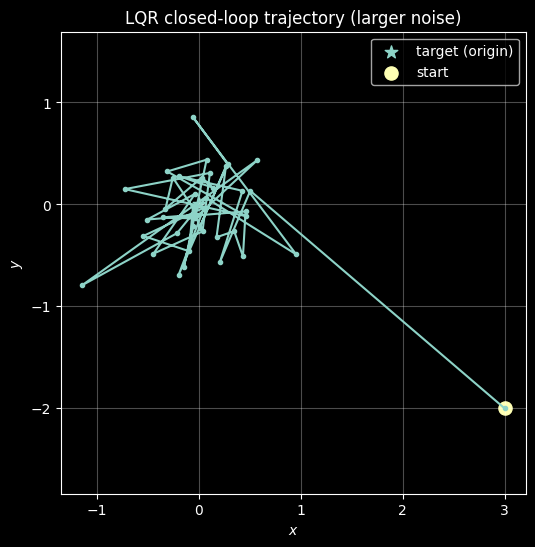

In [5]:
def plot_trajectory(xs, title):
    plt.figure(figsize=(6,6))
    plt.plot(xs[:,0], xs[:,1], marker="o", markersize=3)
    plt.scatter([0],[0], s=90, marker="*", label="target (origin)")
    plt.scatter([xs[0,0]],[xs[0,1]], s=90, label="start")
    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.axis("equal")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_trajectory(x_small, "LQR closed-loop trajectory (small noise)")
plot_trajectory(x_big,   "LQR closed-loop trajectory (larger noise)")

### Control magnitude over time (sanity check)

We visualize $\|a_t\|_2$.

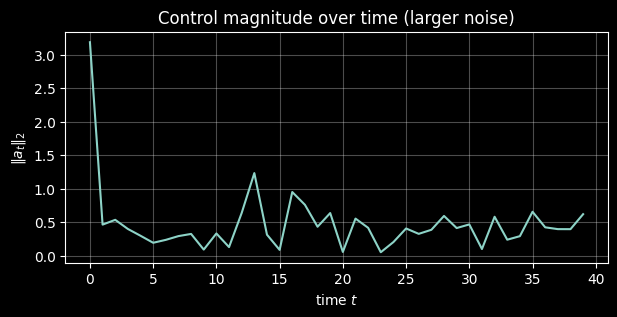

In [6]:
def plot_control_norm(u, title):
    norms = np.linalg.norm(u, axis=1)
    plt.figure(figsize=(7,3))
    plt.plot(norms)
    plt.title(title)
    plt.xlabel("time $t$")
    plt.ylabel(r"$\|a_t\|_2$")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_control_norm(u_small, "Control magnitude over time (small noise)")
plot_control_norm(u_big,   "Control magnitude over time (larger noise)")

### Value contours + control vector field (best 2D intuition)

For LQR, the cost-to-go at time $t$ is:
$$
J_t(s)= s^\top P_t s
$$

We show:
- contours of $J_t(s)$
- arrows of $a=-K_t s$

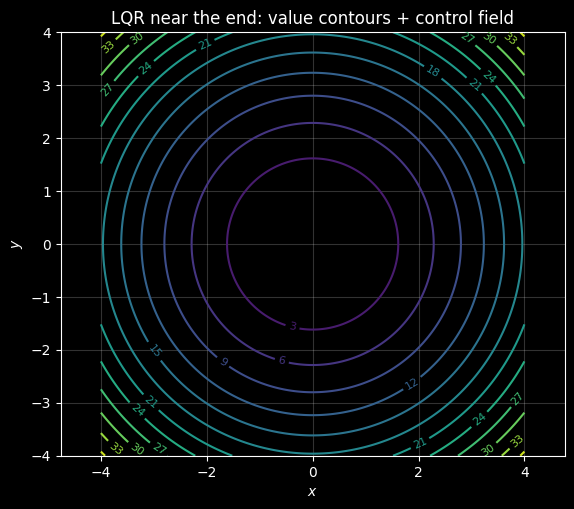

In [7]:
def plot_value_contours_and_policy(P, K, title, lim=4.0, n=25):
    xs = np.linspace(-lim, lim, 200)
    ys = np.linspace(-lim, lim, 200)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.stack([XX, YY], axis=-1)  # (H,W,2)

    J = np.einsum("...i,ij,...j->...", grid, P, grid)

    plt.figure(figsize=(6.5,5.5))
    cs = plt.contour(XX, YY, J, levels=12)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.title(title)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.grid(True, alpha=0.2)

    gx = np.linspace(-lim, lim, n)
    gy = np.linspace(-lim, lim, n)
    GX, GY = np.meshgrid(gx, gy)
    S = np.stack([GX, GY], axis=-1)
    Actrl = -np.einsum("ij,...j->...i", K, S)
    plt.quiver(GX, GY, Actrl[...,0], Actrl[...,1], angles="xy", scale_units="xy", scale=10.0, width=0.003)

    plt.axis("equal")
    plt.show()

plot_value_contours_and_policy(P_list[0],   K_list[0],   "LQR at t=0: value contours + control field")
plot_value_contours_and_policy(P_list[T-1], K_list[T-1], "LQR near the end: value contours + control field")

### Optional: one 3D plot of the value surface

We keep this as a single, meaningful 3D plot:
$$
J_0(x,y) = \begin{bmatrix}x & y\end{bmatrix} P_0 \begin{bmatrix}x \\ y\end{bmatrix}.
$$

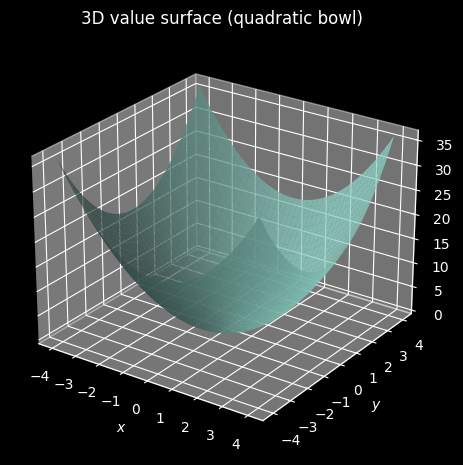

In [11]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_value_surface_3d(P, lim=4.0):
    xs = np.linspace(-lim, lim, 120)
    ys = np.linspace(-lim, lim, 120)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.stack([XX, YY], axis=-1)
    J = np.einsum("...i,ij,...j->...", grid, P, grid)

    fig = plt.figure(figsize=(7.5,5.5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(XX, YY, J, alpha=0.80, linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$J_0(x,y)$")
    ax.set_title("3D value surface (quadratic bowl)")
    ax.view_init(elev=25, azim=-55)
    plt.show()

plot_value_surface_3d(P_list[0], lim=4.0)

## Diagnostics / Sanity checks

### 1) Does $\Sigma_w$ change the policy?

In LQR, the gains $K_t$ do **not** depend on $\Sigma_w$. 

We'll verify by recomputing the recursion (which never uses $\Sigma_w$).

In [9]:
K_list2, P_list2 = lqr_finite_horizon(A, B, Q, R, Qf, T)
max_diff = max(np.max(np.abs(K_list[t] - K_list2[t])) for t in range(T))
print("max |K_t - K_t2|:", max_diff)

max |K_t - K_t2|: 0.0


### 2) Time dependence in finite-horizon LQR

Finite-horizon LQR generally yields a **sequence** $K_t$.

We'll plot $\|K_t\|_F$ over time.

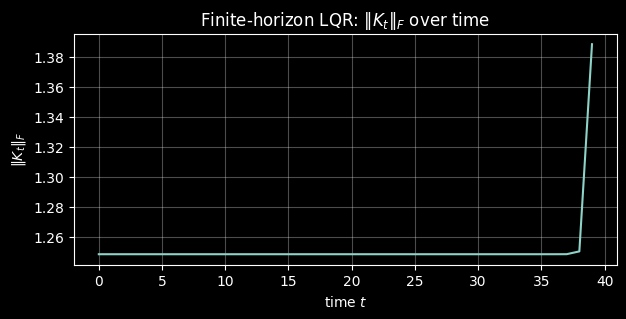

In [10]:
K_norms = np.array([np.linalg.norm(K, ord="fro") for K in K_list])
plt.figure(figsize=(7,3))
plt.plot(K_norms)
plt.title(r"Finite-horizon LQR: $\|K_t\|_F$ over time")
plt.xlabel("time $t$")
plt.ylabel(r"$\|K_t\|_F$")
plt.grid(True, alpha=0.3)
plt.show()

## Key Takeaways (Lesson 19)

### When to use these ideas
- **State-action rewards $R(s,a)$**:
  - actions have different costs (energy, risk, wear-and-tear)

- **Finite-horizon MDPs**:
  - real deadlines (limited steps, limited battery, limited time)
  - solved by backward dynamic programming

- **LQR**:
  - local linear dynamics + quadratic costs
  - exact solution via backward recursion
  - policy gains do not depend on $\Sigma_w$ 

### Failure modes
- Finite horizon:
  - optimal policy can be non-stationary; plotting only one time slice can mislead

- LQR:
  - sensitive to modeling: linearization and quadratic cost are approximations in real systems
  - action penalties too small $\Rightarrow$ unrealistically aggressive control
  - action penalties too large $\Rightarrow$ slow convergence

### Practical diagnostics
- Visualize $V_t^\*(s)$ (or $P_t$ contours) at multiple time steps.
- Plot controller vector field: does it point toward your goal region?
- Monitor control magnitudes: are they plausible for your actuator limits?

### Connections forward
- Finite-horizon DP is the backbone for time-dependent planning.
- LQR is the canonical “solvable” continuous-state case and motivates:
  - linearization-based control
  - model-based RL (learn $A,B$ from data, then plan)